# GITT analysis
In this notebook we will use cellpy to extract the open circuit voltages (OCV) from a GITT measurement. The extracted OCVs will be plotted, and the results saved in .csv format."

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

import cellpy
from cellpy.utils import plotutils

In [2]:
# Comment out this when running the notebook locally to get interactive plots
import plotly.io as pio
pio.renderers.default = "png"

Set filepath and load the datafile:

In [3]:
filedir=pathlib.Path("data") # foldername within the same directory
c = cellpy.get(filedir / '20210210_FC.h5')

Produce an overview plot to identify cycle numbers for the GITT experiment (for an interactive version of this plot, you have to have `plotly` installed):

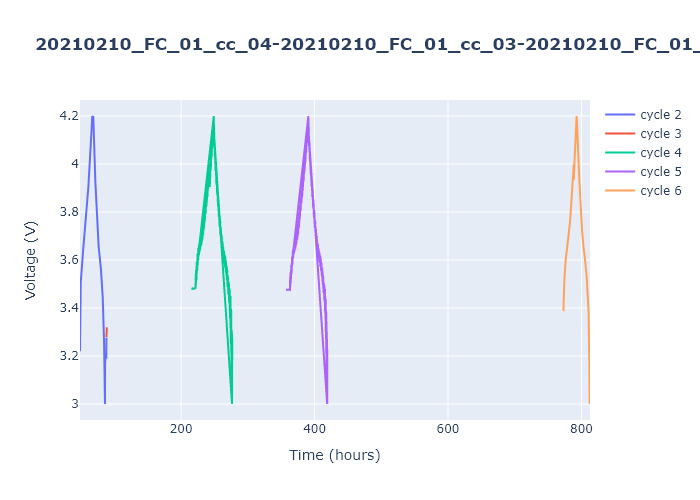

In [4]:
plotutils.cycle_info_plot(c, cycle=list(range(2,7)))

### OCV extraction
From the overview plot above, we can identify the GITT cycles to be cycle number 4 and 5. In the following, we will focus on cycle 5 only.

For further analysis, we create the **step table**, called  ``steps``, a dataframe that contains a lot ofnformation on all the cycle steps for the cell.

In the following, we apply several filters to ``steps``, to eventually extract OCV voltages and corresponding capacities:

1. **``steps_cycle``**: Extract the rows specifically for the selected GITT cycle (here: cycle Nr 5).


NB: For simplicity, ``steps_cycle`` only contains rows relevant for further analysis, i.e. *"cycle", "step""charge_last", "discharge_last", "voltage_first" ,"voltage_last", "type"*."

In [5]:
GITT_cycle=5
c.make_step_table(usteps=True)
steps=c.data.steps
steps_cycle=steps.loc[(steps.cycle == GITT_cycle),["cycle", "step","charge_last", "discharge_last", "voltage_first" ,"voltage_last", "type"]]

Taking a closer look at the created ``steps_cycle`` dataframe:

- `steps_cycle.head(10)` to view the first 10 rows
- `steps_cycle.tail(10)` to view the last 10 rows

In [6]:
steps_cycle.tail(10)

,cycle,step,charge_last,discharge_last,voltage_first,voltage_last,type
755,5,8,0.003358,0.003258,3.212396,3.343531,ocvrlx_up
756,5,7,0.003358,0.003294,3.330632,3.139919,discharge
757,5,8,0.003358,0.003294,3.162645,3.314970,ocvrlx_up
758,5,7,0.003358,0.003330,3.302993,3.080647,discharge
759,5,8,0.003358,0.003330,3.102759,3.283338,ocvrlx_up
760,5,7,0.003358,0.003366,3.272282,3.008170,discharge
761,5,8,0.003358,0.003366,3.029361,3.246485,ocvrlx_up
762,5,7,0.003358,0.003392,3.233587,2.999878,discharge
763,5,10,0.003358,0.003392,3.010627,3.010627,ir
764,5,11,0.003358,0.003392,3.037038,3.228980,ocvrlx_up


2. To extract the OCV voltages, we then filter the `steps_cycle` dataframe for 
    - the OCV relaxation steps on discharge, ``steps_ocv_dch``, of type *oxvrlx_up* (and *rest*), corresponding to ``step==3``, and
    - the OCV relaxation steps on charge ``steps_ocv_cha``, of type *oxvrlx_down* (and *rest*), corresponding to ``step==8``.
Thereby we obtain two new dataframes

In [7]:
steps_ocv_cha=steps_cycle.loc[steps_cycle.step==3]
steps_ocv_dch=steps_cycle.loc[steps_cycle.step==8]

In [8]:
steps_ocv_cha.head(5)

,cycle,step,charge_last,discharge_last,voltage_first,voltage_last,type
390,5,3,0.000036,0.0,3.512440,3.487564,rest
392,5,3,0.000072,0.0,3.518582,3.494320,rest
394,5,3,0.000109,0.0,3.524724,3.499848,rest
396,5,3,0.000145,0.0,3.530559,3.505991,rest
398,5,3,0.000181,0.0,3.537315,3.513054,rest


The voltages at the end of these steps (`voltage_last`), contain the (pseudo-) OCV voltages:

In [9]:
V_cha =  steps_ocv_cha.voltage_last.reset_index(drop=True)
V_dch =  steps_ocv_dch.voltage_last.reset_index(drop=True)
cap_cha= steps_ocv_cha.charge_last.reset_index(drop=True)*1000 #*1000 to convert to mAh
cap_dch= steps_ocv_dch.discharge_last.reset_index(drop=True)*1000 #*1000 to convert to mAh

To plot our results, we additionally get the entire voltage vs capacity curves for the selected GITT cycle, employing the `.get_ccap` and `.get_dcap` methods. The cell mass is used to convert from gravimetric capacity (mAh/g) to capacity (mAh).


In [10]:
c.make_step_table(usteps=False)
ccap = c.get_ccap(cycle=GITT_cycle)
dcap = c.get_dcap(cycle=GITT_cycle)
mass=c.get_mass() # in mg

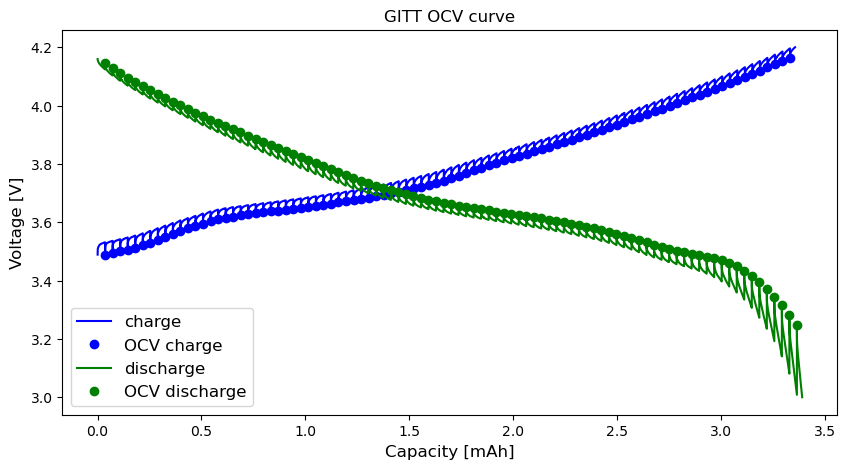

In [11]:
fig, ax = plt.subplots()
ax.plot(ccap["charge_capacity"]*mass/1000, ccap["voltage"], color='blue', label="charge")
ax.plot(cap_cha, V_cha, "bo", label="OCV charge")
ax.plot(dcap["discharge_capacity"]*mass/1000, dcap["voltage"], color="green", label="discharge")
ax.plot(cap_dch, V_dch, "go", label="OCV discharge")
plt.xlabel("Capacity [mAh]", fontsize=12)
plt.ylabel("Voltage [V]", fontsize=12)
plt.title("GITT OCV curve",fontsize=12)
#plt.ylim(0, 0.91)
#plt.xlim(0, 4.70)
ax.legend(fontsize=12)
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

### Saving the data
Concatenate the OCV voltages and capacities into a dataframe, and save as a .csv file.

In [12]:
OCV_cha = pd.concat([cap_cha, V_cha], axis=1, keys=["Charge_cap_mAh", "OCV_V"])
OCV_dch = pd.concat([cap_dch, V_dch], axis=1, keys=["Discharge_cap_mAh", "OCV_V"])

In [13]:
#OCV_cha.to_csv('GITT_OCV_cycle'+str(GITT_cycle)+'_cha.csv',index=False)
#OCV_dch.to_csv('GITT_OCV_cycle'+str(GITT_cycle)+'_dch.csv',index=False)